In [1]:
import matplotlib.pyplot as plt
import json

from gluonts.dataset.repository.datasets import get_dataset
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions

from pts.model.deepar import DeepAREstimator
from pts.modules.distribution_output import ImplicitQuantileOutput
from pts import Trainer
from pts.dataset.repository.datasets import dataset_recipes

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/json.py:45: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [2]:
dataset = get_dataset("m5", regenerate=False)

In [3]:
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Recommended prediction horizon: 28
Frequency of the time series: D


In [4]:
dataset.metadata.prediction_length*2

56

In [5]:
estimator = DeepAREstimator(
    distr_output=ImplicitQuantileOutput(output_domain="Positive"),
    cell_type='GRU',
    input_size=63,
    num_cells=64,
    num_layers=3,
    dropout_rate=0.2,
    use_feat_dynamic_real=True,
    use_feat_static_cat=True,
    cardinality=[json.loads(cat_feat_info.cardinality) for cat_feat_info in dataset.metadata.feat_static_cat][0],
    embedding_dimension = [4, 4, 4, 4, 16],
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*2,
    freq=dataset.metadata.freq,
    scaling=True,
    trainer=Trainer(device=device,
                    epochs=1,
                    learning_rate=1e-3,
                    num_batches_per_epoch=120,
                    batch_size=256,
                   )
)

In [6]:
import warnings
warnings.filterwarnings('ignore')
predictor = estimator.train(dataset.train, num_workers=0)

  0%|          | 0/119 [00:00<?, ?it/s]

In [7]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [8]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [9]:
import warnings
warnings.filterwarnings('ignore')
evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation: 100%|█████████████████████| 30490/30490 [00:00<00:00, 536047.55it/s]
/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/json.py:45: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3.8/site-packages/gluonts/json.py:45: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Volumes/GoogleDrive/我的雲端硬碟/github/gluonts_fund_price_forecast/env/lib/python3

In [10]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 5.053855745420831,
    "abs_error": 882027.4042487043,
    "abs_target_sum": 1183626.0,
    "abs_target_mean": 1.386433491074357,
    "seasonal_error": 0.9207256181588896,
    "MASE": 1.5145273459021142,
    "MAPE": 0.8679531216271946,
    "sMAPE": 1.715873472769783,
    "MSIS": 23.569875262629225,
    "QuantileLoss[0.1]": 234154.56754037784,
    "Coverage[0.1]": 0.5629609239563322,
    "QuantileLoss[0.2]": 452760.878809207,
    "Coverage[0.2]": 0.5649873494822658,
    "QuantileLoss[0.3]": 634048.4818386505,
    "Coverage[0.3]": 0.5737548610785739,
    "QuantileLoss[0.4]": 778254.9416045647,
    "Coverage[0.4]": 0.5895844070655485,
    "QuantileLoss[0.5]": 882027.405381787,
    "Coverage[0.5]": 0.6134657733214637,
    "QuantileLoss[0.6]": 942607.4573670258,
    "Coverage[0.6]": 0.6453228224710679,
    "QuantileLoss[0.7]": 945535.003063216,
    "Coverage[0.7]": 0.6933127957644191,
    "QuantileLoss[0.8]": 879384.5965573601,
    "Coverage[0.8]": 0.756252635524528,
    "Quant

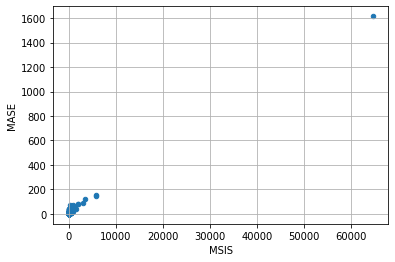

In [11]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()